# This was used  to generate hacky proof of principle data used in the RSC AIChem conference in Sept 2020

In [28]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
import operator
import functools
import os
import gif
import h5py
import scipy.linalg

from skspatial.objects import Point, Vector, Triangle
from operator import attrgetter
from scipy.constants import golden
from IPython.display import HTML

In [2]:
# Constants
_unit_length = np.sqrt(1+(golden*golden))
# the two distances we need for the coordinates.
_c1 = 1 / _unit_length
_c2 = golden / _unit_length
# The points that make up an icosahedron in space, circumradius 1, centered around 0,0,0
_points = [
        Point([-_c1,  _c2,   0]),
        Point([ _c1,  _c2,   0]),
        Point([ _c1, -_c2,   0]),
        Point([-_c1, -_c2,   0]),
        Point([-_c2,   0, -_c1]),
        Point([ _c2,   0, -_c1]),
        Point([ _c2,   0,  _c1]),
        Point([-_c2,   0,  _c1]),
        Point([  0,  _c1, -_c2]),
        Point([  0,  _c1,  _c2]),
        Point([  0, -_c1,  _c2]),
        Point([  0, -_c1, -_c2])
        ]

_edges = [
    frozenset([0, 1]),
    frozenset([8, 1]),
    frozenset([5, 1]),                 
    frozenset([6, 1]),
    frozenset([9, 1]),                 
    frozenset([0, 8]),
    frozenset([8, 5]),                 
    frozenset([5, 6]),
    frozenset([6, 9]),                 
    frozenset([9, 0]),                 
    frozenset([0, 4]),
    frozenset([4, 8]),
    frozenset([8, 11]),                 
    frozenset([11, 5]),
    frozenset([5, 2]),                 
    frozenset([2, 6]),
    frozenset([6, 10]),                 
    frozenset([10, 9]),
    frozenset([9, 7]),                 
    frozenset([7, 0]),   
    frozenset([4, 11]),
    frozenset([11, 2]),
    frozenset([2, 10]),                 
    frozenset([10, 7]),
    frozenset([7, 4]),                 
    frozenset([4, 3]),
    frozenset([11, 3]),                 
    frozenset([2, 3]),
    frozenset([10, 3]),                 
    frozenset([7, 3]) 
]

# Used to make sure the ico will fit in a 3D render
_scale = np.array(_points).flatten('K')

# How high to draw triangles for 2D output
_triangle_2d_hypotenuse = 6
_triangle_2d_height = np.sqrt( _triangle_2d_hypotenuse**2 - (_triangle_2d_hypotenuse/2)**2)

In [11]:
class Molecule(object):
    """ Holds a molecule
    """
    
    # Load the standard colours and convert into the right format for matplotlib.
    _colour_frame = pd.read_csv(os.path.join("JMolColors-master","JMolColors-master","jmolcolors.csv"))
    _colour_list = {}
    for _,a in _colour_frame.iterrows():
        _colour_list[a['atom']] = (a['R'] / 255.0, a['G'] / 255.0, a['B'] / 255.0)
    # for reasons, override carbon and hydrogen
    _colour_list['C'] = (0.0, 0.0, 0.0)
    _colour_list['H'] = (0.0, 0.5, 0.5)
    
    @classmethod
    def get_atom_colour(cls, atom):
        """ Returns RGB color tuple corresponding to atom
        :param str atom: symbol for atom
        """
        return cls._colour_list[atom]
    
    @classmethod
    def get_atom_colour_list(cls, atom_list):
        """ Get a list of the corresponding colours for a list of atoms.
        """
        return [cls.get_atom_colour(a) for a in atom_list]
    
    @staticmethod
    def _atoms_from_mol_file(mol_file,no_of_atoms):
        """Grabs the atoms from a read in version of a molfile
        """
        chopped_mol=mol_file.split('\n')[4:]
        atom_list=[]
        for idx in range(no_of_atoms):
            line=chopped_mol[idx].split(' ')
            data=[x for x in line if not x =='']
            atom_list.append(data[3])
        return atom_list
    
    def _parse_conformer(self):
        self.coords = self.conformer.GetPositions()
        # now scale them to fit the sphere.
        coords_max = max(self.coords.flatten()) / 0.75
        self.coords /= coords_max
        self.coords_x = self.coords[:,0]
        self.coords_y = self.coords[:,1]
        self.coords_z = self.coords[:,2]
    
    def get_atom(self, idx):
        """ Get the RDKit Atom object by index
        """
        return self.molecule.GetAtoms()[idx]
    
    def __init__(self,smiles_string):
        """ Factory method to build a molecule from a smiles string.
        """
        # Parse the molecule
        base_m = rdkit.Chem.MolFromSmiles(smiles_string)
        rdkit.Chem.AllChem.EmbedMolecule(base_m)
        # Add the hydrogens
        molecule = rdkit.Chem.AddHs(base_m)
        rdkit.Chem.AllChem.EmbedMolecule(molecule)
        # use MMFF94 to minimise and make a nice structure
        rdkit.Chem.AllChem.MMFFOptimizeMolecule(molecule)
        
        # get a conformer, any conformer and parse it.
        self.conformer = molecule.GetConformers()[0]
        self._parse_conformer()
        
        atom_count = self.conformer.GetNumAtoms()
        
        # get molefile
        mol_file=rdkit.Chem.MolToMolBlock(molecule)
        self.atom_list=Molecule._atoms_from_mol_file(mol_file, atom_count)
        self.colour_list = Molecule.get_atom_colour_list(self.atom_list)
        
        self.molecule = molecule
        self.smiles = smiles_string
    
    def draw3D(self, target):
        """ Draw the object in 3d
        """
        target.scatter(self.coords_x, self.coords_y, self.coords_z, self.colour_list)
    
    def __repr__(self):
        return repr("Molecule: {}".format(self.smiles))
        

In [95]:
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
m.get_atom(0).GetMass()
m.coords[0]
dir(m.get_atom(0))
m.get_atom(0).GetSymbol()

'C'

In [85]:
class Face(object):
    """A class to define a face on an icosphere
    a,b,c are the points in 3D space of points on an icosphere
    u,v are the coordinates on a 2D plane corresponding to the unfolded icosphere net
    children are the faces at the next layer of magnification (anti coarse graining of a sphere)
    atoms are the atoms that project onto that face"""
    
    @staticmethod
    def face_get_colour(face):
        """ hook function to look up the individual colour of a face.
        Mostly implemented as a demonstration of how to do the plugin approach to calculation.
        """
        if not face.atoms:
            # Nothing to see here.
            return (1.0, 1.0, 1.0)

        if len(face.atoms) == 1:
            # Only one choice
            return Molecule.get_atom_colour(face.molecule.get_atom(face.atoms[0][1]).GetSymbol())

        atom_list = [face.molecule.get_atom(x).GetSymbol() for _,x in face.atoms]
        atom1 = [ a for a in atom_list if a is not "H"]
        atom2 = [ a for a in atom1 if a is not "C"]

        if atom2:
            # Something more interesting than Carbon / Hydrogen. Pick the first
            return Molecule.get_atom_colour(atom2[0])
        if atom1:
            # Carbon at least
            return Molecule.get_atom_colour("C")
        # must have been multiple hydrogens
        return Molecule.get_atom_colour("H")    
    
    
    @staticmethod
    def face_get_masses(face):
        """ Returns the masses of the atoms associated with this face as a 3-tuple:
            1) mass of the atom closest to the centre of the molecule
            2) mass of the atom furthest to the centre of the molecule
            3) total mass of all atoms associated with this face
        """
        min_distance =  max_distance = None
        min_mass =  max_mass = total_mass = 0.0
        # TODO: this is clunky. FIX IT
        for distance, idx in face.atoms:
            atom_mass = face.molecule.get_atom(idx).GetMass()
            if not min_distance or distance < min_distance:
                min_distance = distance
                min_mass = atom_mass
            if not max_distance or distance > max_distance:
                max_distance = distance
                max_mass = atom_mass
            total_mass += atom_mass
        
        return (min_mass, max_mass, total_mass)
    
    # The function to use when determining the values of a face.
    _lookup_func = face_get_colour
    
        
    def __init__(self, molecule, a=None, b=None, c=None):
        self.molecule = molecule # the molecule we are drawing from.
        self.a = Vector(a) # these are vectors from 0,0,0 to x y z etc
        self.b = Vector(b)
        self.c = Vector(c)
        self.triangle = Triangle(a,b,c)
        self.normal = self.triangle.normal()
        self.u = None
        self.v = None
        self.w = None
        self.midpoint = None
        self.children = []
        self.atoms = [] # list of (distance from centre, atom_index) tuples
        

    def create_children(self, levels_to_do=1):
        """triangles are formed at the midpoints of edges
            we label points in a clockwise manner ALWAYS"""
        if self.children:
            # check we not got no children already
            raise ValueError("create children called on face with children already assigned")
        if levels_to_do == 0:
            return
        # ab is the left hand edge of the triangle
        # finds the mid-point on the line defined by x, y
        # AND PROEJCTS IT TO THE UNIT SPHERE EASY!
        ab = ((self.a + self.b) /2).unit()
        bc = ((self.b + self.c) /2).unit()
        ca = ((self.c + self.a) /2).unit()
        self.children = [ # the four new triangles
            Face(self.molecule, self.a, ab, ca), # 1 bottom left
            Face(self.molecule, ab, self.b, bc), # 2 top
            Face(self.molecule, ca, bc, self.c), # 3 bottom right
            Face(self.molecule, ab, bc, ca)] # 4 middle
        for child in self.children:
            # this should work...
            child.create_children(levels_to_do-1)

    def get_mesh(self):
        """ Return the mesh for this face as an array.
        """
        if self.children:
            return functools.reduce(operator.add, [c.get_mesh() for c in self.children])
        
        # Leaf node
        return [[self.a, self.b, self.c]]
    
    def get_values(self):
        """ Use the class lookup function to determine the values associated with this face.
        e.g. the colours to render with.
        """
        return self._lookup_func()
    
    def _get_colour(self):
        """ hard coded version of _get_values that always uses face_get_colour to determine values.
        """
        return self.face_get_colour(self)
    
    def _map_coords(self, u, v, w):
        """ Inner function for working out the file locations
            uvw need to be specified in clockwise order.
        """
        ux, uy = u
        vx, vy = v
        wx, wy = w
        self.u = u
        self.v = v
        self.w = w
        
        
        self.midpoint_x = (ux + vx + wx) / 3 
        # only going to approximate Y
        self.midpoint_y = (min(uy, vy, wy) + max(uy, vy, wy)) / 2
        
        self.midpoint = self.midpoint_x, self.midpoint_y
        
        if self.children:
            uv = ((ux + vx) / 2, (uy + vy) / 2)
            vw = ((vx + wx) / 2, (vy + wy) / 2)
            wu = ((wx + ux) / 2, (wy + uy) / 2)
            self.children[0]._map_coords(u, uv, wu)
            self.children[1]._map_coords(uv, v, vw)
            self.children[2]._map_coords(wu, vw, w)
            self.children[3]._map_coords(uv, vw, wu)
    
    def _draw(self, plot):
        """ Inner function for the drawing. Plots this face between the points shown.            
        """
        if not self.midpoint:
            raise ValueError("_draw called before _map_coords")
        if not self.children:
            xs = np.array([x for x,_ in [self.u, self.v, self.w]])
            ys = np.array([y for _,y in [self.u, self.v, self.w]])
            tris = np.array([[0,1,2]])
            tri = matplotlib.tri.Triangulation(xs, ys, tris)
        
            x=matplotlib.pyplot.Polygon(np.array([self.u, self.v, self.w]), 
                                        ec='k', 
                                        closed=True, 
                                        color=self._get_colour())
            plot.gca().add_patch(x)
        
            return
        for child in self.children:
            child._draw(plot)        
        
    def add_atom(self, location, idx):
        """ Add a specific atom to the face
        """
        self.atoms.append((scipy.linalg.norm(location), idx))
        if not self.children:
            return
        best_child = None
        best_angle = None
        for child in self.children:
            angle = location.angle_between(child.normal)
            if best_child is None or angle < best_angle:
                best_child = child
                best_angle = angle
        best_child.add_atom(location, idx)

    def get_leaf_faces(self):
        """ Returns a list of the lowest level faces
        """
        if self.children:
            if self.children[0].children:
                # recursive case
                result = []
                for child in self.children:
                    result += child.get_leaf_faces()
                return result
            else:
                # this is the parent of a set of leaves
                return self.children
        else:
            raise ValueError("get_leaf_faces reached actual leaf face. Shouldn't happen.")
    
    def __repr__(self):
        """ Print the Face."""
        #output = "Face: {}".format(self.triangle)
        output = "Face"
        
        if self.midpoint:
            output += " at {}".format(self.midpoint)
            
       # if self.u:
        #    output += " ({},{},{})".format(self.u, self.v, self.w)
            
        if self.atoms:
            output += " with {}".format(self.atoms)
        return repr(output)

In [86]:
class TopFace(Face):
    """ A Face that exists at the top level of the icosahedron.
        Contains extra functions  that inner faces do not need.
    """
    def __init__(self, molecule, a_idx, b_idx, c_idx):
        super().__init__(molecule, _points[a_idx],_points[b_idx],_points[c_idx])
        self.edges = {
            (a_idx,b_idx),
            (b_idx,c_idx),
            (c_idx,a_idx)
        }
        self.indices = [a_idx, b_idx, c_idx]
        self.neighbours = []
        # Where in the 2D unwrapped grid to render this face
        self.grid_coords = None                        
        
    def get_edges(self):
        """ Returns a set of the edges that this face has.
        """
        return [frozenset(x) for x in self.edges]
    
    def get_point_indices(self):
        """ Returns a set of the point indices that this face has.
        """
        return self.indices
    
    def clear_grid(self):
        """ Clear the grid before a fresh unwrap."""
        self.grid_coords = None                

    def _set_grid_first_row(self, top_idx, column):
        """ Recurse along the top row of the grid, initialising them
        """
        if top_idx not in self.indices:
            raise ValueError("Invalid point index.")
            
        if self.grid_coords is not None:
            # we've come all the way around. Stop
            return        
        
        self.grid_coords = (0, column)
        # Now find the faces to update.
        # next point is the point adjacent to the top point on the edge shared with the next
        # face on the top row. It is also a point shared with the adjacent face on the second row
        next_point = [b for a,b in self.edges if a==top_idx][0]
        next_faces = [n for n in self.neighbours if next_point in n.indices]
        assert(len(next_faces)==2)
        for next_face in next_faces:
            if top_idx in next_face.indices:
                # This is the one at the top of the next column.
                next_face._set_grid_first_row(top_idx,column+1)
                continue
            
            # This is the one below us on the second row  
            assert(next_face.grid_coords is None)
            next_face.grid_coords = (1, column)
            
            # Find the one in the third row.
            third_face_candidates = [f for f in next_face.neighbours if (next_point in f.indices and f is not self)]
            assert(len(third_face_candidates)==1)
            third_face = third_face_candidates[0]
            assert(third_face.grid_coords is None)
            third_face.grid_coords = (2, column)
            
            # finally the fourth row.
            # two ways we could do it:
            # a. It is the neighbour of third_face that shares a point with next_face
            # b. It is the neighbour of third_face that is on the edge that does not contain next_point
            # Going with a.
            point_2_4 = [b for a,b in next_face.edges if a==next_point][0]
            fourth_face_candidates = [f for f in third_face.neighbours if (point_2_4 in f.indices and f is not next_face)]
            if( len(fourth_face_candidates) != 1):
                print("Third face neighbours:\n{}".format(third_face.neighbours))
                print("Second face:\n{}".format(next_face))
                print("Third face:\n{}".format(third_face))
                print("Second_fourth point: {}".format(point_2_4))
                print(fourth_face_candidates)
                
            assert(len(fourth_face_candidates)==1)
            fourth_face = fourth_face_candidates[0]
            assert(fourth_face.grid_coords is None)
            fourth_face.grid_coords = (3, column)                       
        
        
    def set_grid(self, top_idx):
        """ Initialise the grid, with the point marked as top_idx as the top point
            and self as 0,0
        """        
        self._set_grid_first_row(self.indices[top_idx], 0)
    
    def plot2D(self, height=_triangle_2d_height, width=_triangle_2d_hypotenuse):
        """
        Compute the 2D projection of this face
        """
        if self.grid_coords is None:
            raise ValueError("_project2D called with no grid setup")
        y,x = self.grid_coords
        
        # Time to map from grid space to 2d space
        # If we are on an even numbered row, then we are facing up and our coords will be
        #    v
        #   / \
        #  u - w
        # If we are on an odd numbered row, then we are facing down and our coords will be
        #  u - v
        #   \ /
        #    w        
        
        # first u
        ux = (x +(y//2)/2)* width
        uy = (2 - y//2)*height
        
        if y%2 == 0:
            # even row            
            vx, vy = ux + (width/2.0), uy+height
            wx, wy = ux + width, uy
        else:
            # odd row
            vx, vy = ux + width, uy
            wx, wy = ux + (width/2.0), uy-height
        
        self._map_coords( (ux,uy), (vx,vy), (wx,wy) )
    
    def draw2D(self, plot, height=_triangle_2d_height, width=_triangle_2d_hypotenuse):
        """
        Draw this face onto the supplied plot
        """
        if self.grid_coords is None:
            raise ValueError("draw2D called with no grid setup")
        
        
        self._draw(plot)    

    
    def get_ordered_leaf_faces(self):
        """ Returns a list of the lowest level faces, ordered by their locations
                1           1 2 3
               2 3           4 5 
              4 5 6           6
              etc.
        """        
        if not self.midpoint:
            raise ValueError("get_ordered_leaf_faces called without first plotting.")
            
        face_list = self.get_leaf_faces()
        partial_list = sorted(face_list, key=attrgetter('midpoint_x'))
        return sorted(partial_list, key=attrgetter('midpoint_y'), reverse=True)    
            
    
    def __repr2__(self):
        """ Print the Face."""
        output = "Face: {}".format(self.indices)
        
        if self.midpoint:
            output += " at {}".format(self.midpoint)
            
        if self.u:
            output += " ({},{},{})".format(self.u, self.v, self.w)
            
        if self.atoms:
            output += " with {}".format(self.atoms)
        return repr(output)

In [106]:
class Ico(object):
    """A class to define an icsahedron or icosphere.
    """
    
    def _add_molecule(self, molecule):
        """ Add a molecule to the ico, marking each face nearest each atom
        """
        for idx, location in enumerate(molecule.coords):
            self._add_atom(Vector(location), idx)
            
    def __init__(self, molecule, level=0):
        """ Create a new icosphere.
        Level indicates how many subdivisions to make, 0 (default) will give you an icosohedron.
        All icospheres are centred around the origin with a cicumradius of 1
        """
        self.molecule = molecule
        self.faces = [
                # Top row, around point 1
                TopFace(molecule, 0, 1, 8),
                TopFace(molecule, 8, 1, 5),
                TopFace(molecule, 5, 1, 6),
                TopFace(molecule, 6, 1, 9),
                TopFace(molecule, 9, 1, 0),
                # Row 2
                TopFace(molecule, 0, 8, 4),
                TopFace(molecule, 8, 5, 11), 
                TopFace(molecule, 5, 6, 2),
                TopFace(molecule, 6, 9, 10), 
                TopFace(molecule, 9, 0, 7),
                # Row 3
                TopFace(molecule, 4, 8, 11), 
                TopFace(molecule, 11, 5, 2), 
                TopFace(molecule, 2, 6, 10), 
                TopFace(molecule, 10, 9, 7), 
                TopFace(molecule, 7, 0, 4),
                # Bottom row, around point 3
                TopFace(molecule, 4, 11, 3), 
                TopFace(molecule, 11, 2, 3),
                TopFace(molecule, 2, 10, 3), 
                TopFace(molecule, 10, 7, 3),
                TopFace(molecule, 7, 4, 3)
                ]
        
        # Now create a dictionary of which faces have which edge and
        # one of which faces have which point
        self.edge_mappings = {}
        self.point_mappings = {}
        for face in self.faces:
            for edge in face.get_edges():
                try:
                    self.edge_mappings[edge].append(face)
                except KeyError:
                    self.edge_mappings[edge] = [face]
            for idx in face.get_point_indices():
                try:
                    self.point_mappings[idx].append(face)
                except KeyError:
                    self.point_mappings[idx] = [face]
        
        
        # Use this to tell each face what its neighbours are
        for idx in self.edge_mappings:
            if len(self.edge_mappings[idx]) != 2:
                print("{}:{}".format(idx, self.edge_mappings[idx]))
            assert(len(self.edge_mappings[idx])==2)
            l,r = self.edge_mappings[idx]
            l.neighbours.append(r)
            r.neighbours.append(l)
            

        # now perform the subdivisions
        # conditional isn't needed, but why waste the time?
        if level==0:
            return

        for face in self.faces:
            face.create_children(level)
            
        self._add_molecule(self.molecule)
    
    def get_mesh(self):
        """ return the mesh for this object
        """
        return functools.reduce(operator.add, [f.get_mesh() for f in self.faces])
    
    def _draw_init(self):
        self._figure = matplotlib.pyplot.figure()
        self._axes = mpl_toolkits.mplot3d.Axes3D(self._figure)
        self._mesh = i3.get_mesh()

    def _draw_3d(self, a, b):
        """Draw a single 3d frame
            a,b : angles to rotate the view by
        """
        # Load the stuff
        self._axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(self._mesh))
        self._axes.auto_scale_xyz(scale, scale, scale*1.25)
        self._axes.view_init(a,b) 
        matplotlib.pyplot.draw()
    
    def draw3D(self, a=15, b=30):
        """Quick function to draw a single frame
        """
        self._draw_init()
        self._draw_3d(a,b)
        
    def plot2D(self, first_face=0, point_idx=0):
        """Unwrap the icosphere, starting with the specified face, with the indicated point on the top
        """
        # Make sure the request makes sense.
        if first_face < 0 or first_face >= 20 or point_idx < 0 or point_idx >= 3:
            raise ValueError("Face needs to be in range 0..20, point 0..2")
        # clear any grid from previous runs        
        for f in self.faces:
            f.clear_grid()
        
        self.faces[first_face].set_grid(point_idx)
        
        # Now recalculate the grid
        for face in self.faces:
            face.plot2D()
        
        
    def draw2D(self, first_face=0, point_idx=0):
        """Unwrap the ico and draw it, 
        starting with the specified face, with the demarked point up
        """
        # do the plotting
        self.plot2D(first_face, point_idx)
        
        # set up the image
        figure = matplotlib.pyplot.figure()
        matplotlib.pyplot.axis('equal')
        #matplotlib.pyplot.axis('off')
        
        for f in self.faces:
            f.draw2D(figure)
        matplotlib.pyplot.autoscale(enable=True, axis='both')

        matplotlib.pyplot.draw()
    
    def _add_atom(self, location, idx):
        best_face = None
        best_angle = None
        for face in self.faces:
            angle = location.angle_between(face.normal)
            if best_face is None or angle < best_angle:
                best_face = face
                best_angle = angle
        best_face.add_atom(location, idx)

    
    def get_face_list(self):
        """ Returns a list of the leaf faces in the Icosphere
        """
        result = []
        partial_list = sorted(self.faces, key=attrgetter('midpoint_x'))
        ordered_faces = sorted(partial_list, key=attrgetter('midpoint_y'), reverse=True)    
                
        for face in ordered_faces:
            result += face.get_ordered_leaf_faces()
        return result

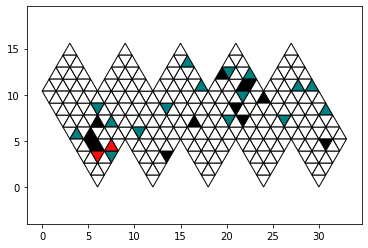

In [115]:
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
i = Ico(m,2)
i.draw2D()

In [97]:
fs=i.get_face_list()
Face._lookup_func = Face.face_get_masses
values = [f.get_values() for f in fs]
np.array(values)

array([[ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 1.008,  1.008,  1.008],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [12.011, 12.011, 12.011],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0

In [98]:
L_alanine_smiles='N[C@@H](C)C(=O)O'
D_alanine_smiles='N[C@H](C)C(=O)O'
cubane_smiles='C12C3C4C1C5C2C3C45'
tamiflu_smiles='CCC(CC)O[C@@H]1C=C(C[C@@H]([C@H]1NC(=O)C)N)C(=O)OCC.OP(=O)(O)O'


In [109]:
i = Ico(1)
m=Molecule(D_alanine_smiles)
i=Ico(m, level=0)
i._add_molecule(m)
for tri in range(20):
    for point in range(3):
        i.draw2D(tri, point)
        matplotlib.pyplot.savefig("R_alanine_{}_{}.png".format(tri,point), dpi=300, bbox_inches='tight')
        matplotlib.pyplot.close()

In [19]:
m=Molecule(tamiflu_smiles)
for i in range(4):
    ic = Ico(i)
    ic.add_molecule(m)
    ic.draw2D()
    matplotlib.pyplot.savefig(os.path.join("outputs", "tamiflu_{}.png".format(i)), dpi=300, bbox_inches='tight')
    matplotlib.pyplot.close()

In [100]:
def rot_ar_x(radi):
    return  np.array([[1, 0, 0, 0],
                      [0, np.cos(radi), -np.sin(radi), 0],
                      [0, np.sin(radi), np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi), 0],
                      [0, 1, 0, 0],
                      [-np.sin(radi), 0, np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0, 0],
                      [np.sin(radi), np.cos(radi), 0, 0],
                      [0, 0, 1, 0],
                     [0, 0, 0, 1]], dtype=np.double)
tforms = {0: rot_ar_x, 1: rot_ar_y, 2: rot_ar_z}

In [21]:
m=Molecule(tamiflu_smiles)
#rdkit.chem.rdMolTransforms.TransformConformer(mol.GetConformer(0), tforms[0](2*np.pi/36)
@gif.frame
def do_frame(i,d):
    rdkit.Chem.rdMolTransforms.TransformConformer(m.conformer, tforms[1](2*np.pi/100))
    m._parse_conformer()
    i = Ico(d)
    i.add_molecule(m)
    i.draw2D()

for d in range(3):
    frames = []
    for i in range(100):
        frame = do_frame(i,d)
        frames.append(frame)

    gif.save(frames, "tamiflu_{}.gif".format(d), duration=50)

NameError: name 'tforms' is not defined

RuntimeError: Requested MovieWriter (ffmpeg) not available

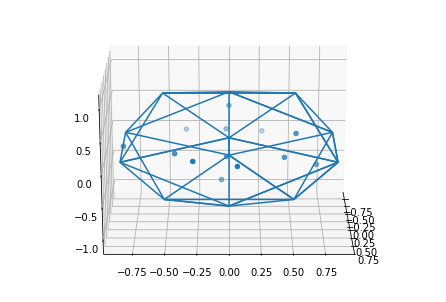

In [101]:
scale = np.array(_points).flatten('K')
figure = matplotlib.pyplot.figure()
axes = mpl_toolkits.mplot3d.Axes3D(figure)
mesh = i.get_mesh()

def draw(a,b):
    # Load the stuff
    m.draw3D(axes)
    axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(mesh))
    axes.auto_scale_xyz(scale, scale, scale*1.25)
    axes.view_init(a,b) 
    matplotlib.pyplot.draw()

#m.draw3D(axes)
#draw(12,15)
    
def frame(i):
    draw(20,i)
from matplotlib import animation, rc
video=animation.FuncAnimation(figure, frame,frames=360, interval=20).to_html5_video()
HTML(video)

In [29]:
np.mean([3.5, 1, 2, 2.5])

2.25

## making a dataset

In [102]:
#import scikitlearn as sklearn
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
#from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import os.path


import math
import random
import collections

x_train_filename='1K_SMILES_strings.txt'
t_train_filename='1K_SMILES_strings_charges.txt'

data_dir = os.path.join(os.path.curdir, 'data')

x_train_data=os.path.join(data_dir, x_train_filename)
t_train_data=os.path.join(data_dir, t_train_filename)

# altering to use a % of the input data for test
fraction_of_test_molecules=0.1
validation_split=0.1
class_to_charge_list=[0,1,-1,-2]

"""TRAINING DATA PREPROCESSING"""
#Convert training data, in the form of txt files of line-by-line SMILES strings and charges into arrays
with open(x_train_data) as my_file:
    SMILES_array = my_file.readlines()

with open(t_train_data) as my_file:
    charges_array = my_file.readlines()

no_of_data_points=int(len(charges_array))
#no_of_test_points=int(fraction_of_test_molecules*no_of_data_points)
#print('{} datapoints, {} randomly selected for test, leaving {} for train'.format(no_of_data_points, no_of_test_points, no_of_data_points-no_of_test_points))


#test_line_nos=random.sample(range(0, no_of_data_points), no_of_test_points)
#train_line_nos=[x for x in range(0, no_of_data_points) if x not in test_line_nos]

#no_of_train_points=int(len(train_line_nos))
#print('Validation split is {}, so {} points val, {} points pure train'.format(validation_split, int(validation_split*no_of_train_points), int(no_of_train_points-(validation_split*no_of_train_points))))
# make new arrays
#X_train = []
#T_train = []
#for i in train_line_nos:
#    X_train.append(SMILES_array[i])
#    T_train.append(charges_array[i])


#X_test = []
#T_test = []
#for i in test_line_nos:
#    X_test.append(SMILES_array[i])
#    T_test.append(charges_array[i])

#print('Randomly assigned test set set up: stats follows:')
#print('Train: {}'.format(collections.Counter(T_train)))
#print('Test: {}'.format(collections.Counter(T_test)))


#Convert testing data, in the form of txt file of line-by-line SMILES strings into arrays
#with open('10_SMILES_strings_test.txt') as my_file:
#    test_SMILES_array = my_file.readlines()

#Convert each item of the training array of SMILES strings into molecules
#mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in X_train]

mols=[]
for SMILES_string in SMILES_array:
    mols.append(Chem.rdmolfiles.MolFromSmiles(SMILES_string))

#Convert training molecules into training fingerprints
bi = {}
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=256) for m in mols]


In [103]:
len(SMILES_array)

1000

In [104]:
i = Ico(4)
m=Molecule(SMILES_array[5])
i.add_molecule(m)
i.draw2D();

AttributeError: 'Ico' object has no attribute 'add_molecule'

In [26]:

fs=i.get_face_list()
colours = [f._get_colour() for f in fs]
np.array(colours);

## This actually builds the dataset!

In [32]:
# hacky 
icosahedron_list_for_SPHERE_PHD=[]
for smiles_string in SMILES_array:
    i = Ico(4)
    m=Molecule(smiles_string)
    i.add_molecule(m)
    i.plot2D();
    fs=i.get_face_list()
    colours = [f._get_colour() for f in fs]
    colours_as_array = np.array(colours);
    icosahedron_list_for_SPHERE_PHD.append(colours_as_array)
    
np.save('1M_icosahedron_list_level4.npy',icosahedron_list_for_SPHERE_PHD)

In [ ]:
len(SMILES_array)

In [16]:
# hacky
smile_count = len(SMILES_array)
# *60 as there are 20 faces with 3 vertices each.
# TODO: this duplicates each vertice 3 times. Fix it
# TODO: This doesn't seperate out the vertices from different faces, nor the faces from different molecules,
#       except by sequence.
output_file = h5py.File(os.path.join("data","1M_augemented_list.hdf5"),"w")
icosahedron_list_for_SPHERE_PHD=np.zeros((smile_count*60, 5120, 3))
augmented_charge_list = np.zeros((smile_count*60))
mol_id_list=np.zeros(smile_count*60)
point_ptr = -1
for mol_idx in range(len(SMILES_array)):
    i = Ico(4)
    smiles_string = SMILES_array[mol_idx]
    charge = int(charges_array[mol_idx]) # '1\n' etc
    m=Molecule(smiles_string)
    i.add_molecule(m)
    for face_idx in range(20):
        for point_idx in range(3):
            point_ptr += 1
            i.plot2D(first_face=face_idx, point_idx=point_idx);
            fs=i.get_face_list()
            colours = [f._get_colour() for f in fs]
            colours_as_array = np.array(colours);
            icosahedron_list_for_SPHERE_PHD[point_ptr] = colours_as_array
            augmented_charge_list[point_ptr] = charge
            mol_id_list[point_ptr] = mol_idx
            
output_file.close()   
#np.save('1M_augemented_icosahedron_list_level4.npy',icosahedron_list_for_SPHERE_PHD)
#np.save('1M_augemented_charge_list.npy',augmented_charge_list)
#np.save('1M_augemented_molID_list.npy',mol_id_list)

In [16]:
smile_count = len(SMILES_array)
# *60 as there are 20 faces with 3 vertices each.
# TODO: this duplicates each vertice 3 times. Fix it
# TODO: This doesn't seperate out the vertices from different faces, nor the faces from different molecules,
#       except by sequence.
outfile.close()
outfile = h5py.File(os.path.join("data","1M_augemented_list.hdf5"),"w")
icosahedron_ds =  outfile.create_dataset("icosahedron_level4", (smile_count*60, 5120, 3))
charge_ds = outfile.create_dataset("charge", (smile_count*60,))
molID_ds = outfile.create_dataset("molID", (smile_count*60,))

### Getting colour icosahedron data

In [17]:
## This is the code to generate the datasets used. Run the hdf5 code below as well
point_ptr = -1
for mol_idx in range(len(SMILES_array)):
    print(mol_idx)
    i = Ico(4)
    smiles_string = SMILES_array[mol_idx]
    charge = int(charges_array[mol_idx]) # '1\n' etc
    m=Molecule(smiles_string)
    i.add_molecule(m)
    for face_idx in range(20):
        for point_idx in range(3):
            point_ptr += 1
            i.plot2D(first_face=face_idx, point_idx=point_idx);
            fs=i.get_face_list()
            colours = [f._get_colour() for f in fs]
            colours_as_array = np.array(colours);
            icosahedron_ds[point_ptr] = colours_as_array
            charge_ds[point_ptr] = charge
            molID_ds[point_ptr] = mol_idx
            
output_file.close()   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
import h5py
with h5py.File(os.path.join("data","1M_augemented_list.hdf5"),"w") as outfile:
    outfile.create_dataset("icosahedron_level4", data=icosahedron_list_for_SPHERE_PHD)
    outfile.create_dataset("charge", data=augmented_charge_list)
    outfile.create_dataset("molID", data=mol_id_list)


In [198]:
DIVISION = 4
m=Molecule('CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2')
i = Ico(m,DIVISION)
i.plot2D(first_face=1, point_idx=1);
len(i.get_face_list())

5120

In [213]:
55 % 50

5

### Getting atom mass icosahedron data

Got to Molecule no.  0
Got to Molecule no.  50
Got to Molecule no.  100
Got to Molecule no.  150
Got to Molecule no.  200
Got to Molecule no.  250
Got to Molecule no.  300
Got to Molecule no.  350
Got to Molecule no.  400
Got to Molecule no.  450
Got to Molecule no.  500
Got to Molecule no.  550
Got to Molecule no.  600
Got to Molecule no.  650
Got to Molecule no.  700
Got to Molecule no.  750
Got to Molecule no.  800
Got to Molecule no.  850
Got to Molecule no.  900
Got to Molecule no.  950


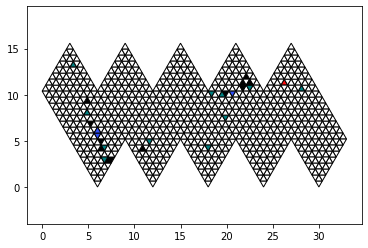

In [223]:
## This is the code to generate the datasets used. Run the hdf5 code below as well
NUM_MAPS_PER_MOLECULE = 60 # how many maps to create
DIVISION = 3 # for the size of icospehre   ##### cahnge this 
outfile = h5py.File(os.path.join("data","1K_list_augmented_div3.hdf5"),"w") ##### change this

if DIVISION == 1:
    NUM_FACES = 80
elif DIVISION == 2:
    NUM_FACES = 320
elif DIVISION == 3:
    NUM_FACES = 1280
elif DIVISION == 4:
    NUM_FACES = 5120

smile_count = len(SMILES_array)
# *60 as there are 20 faces with 3 vertices each.
# TODO: this duplicates each vertice 3 times. Fix it
# TODO: This doesn't seperate out the vertices from different faces, nor the faces from different molecules,
#       except by sequence.
#outfile.close()
icosahedron_ds =  outfile.create_dataset("icosahedron_level3", (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3)) #### change this 
charge_ds = outfile.create_dataset("charge", (smile_count*NUM_MAPS_PER_MOLECULE,))
molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
#smiles_ds = outfile.create_dataset("SMILES_strings", (smile_count*NUM_MAPS_PER_MOLECULE,))
num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 


if NUM_MAPS_PER_MOLECULE == 1:
    NUM_UNWRAPPINGS_TO_DO = 1
    NUM_DIRECTIONS_TO_DO = 1
elif NUM_MAPS_PER_MOLECULE == 60:
    NUM_UNWRAPPINGS_TO_DO = 20
    NUM_DIRECTIONS_TO_DO = 3
else:
    # TODO implement this if you're going to use it!
    # or set the numbers by hand
    print('Error: Unimplemented!')
    pass
                                               
point_ptr = -1                                               
for mol_idx in range(len(SMILES_array)):
    if mol_idx % 50 == 0:
        print('Got to Molecule no. ', mol_idx)
    smiles_string = SMILES_array[mol_idx]#[:-2] # SMILES strings include the \n atm!!!!
    charge = int(charges_array[mol_idx]) # '1\n' etc
    m=Molecule(smiles_string)
    i = Ico(m,DIVISION)
    for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
        for point_idx in range(NUM_DIRECTIONS_TO_DO): 
            point_ptr += 1
            #### create the map (this does not plot a graphics object)
            i.plot2D(first_face=face_idx, point_idx=point_idx);
            fs=i.get_face_list()
            #### grab the atom values or colours or whatever
            Face._lookup_func = Face.face_get_masses
            values = [f.get_values() for f in fs]
            #### create the measurables you want to record
            values_as_array = np.array(values)
            num_atoms = m.molecule.GetNumAtoms() # number of atoms
            num_bonds = m.molecule.GetNumBonds() # number of bonds
            num_heavy_atoms = m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
            num_exact_Mol_Wt = Descriptors.ExactMolWt(m.molecule) # exact molar weight
            MolLogP = Descriptors.MolLogP(m.molecule, includeHs=True) # octanol / water partitian coefficient
            num_H_acceptors = Descriptors.NumHAcceptors(m.molecule)
            num_H_donors = Descriptors.NumHDonors(m.molecule)
            num_heteroatoms = Descriptors.NumHeteroatoms(m.molecule)
            num_valence_electrons = Descriptors.NumValenceElectrons(m.molecule)
            PMI_1 = rdMolDescriptors.CalcPMI1(m.molecule) # principal moment of inertia 1 (smallest)
            PMI_2 = rdMolDescriptors.CalcPMI2(m.molecule) # principal moment of inertia 2
            PMI_3 = rdMolDescriptors.CalcPMI3(m.molecule) # principal moment of inertia 3
            spherocity = rdMolDescriptors.CalcSpherocityIndex  (m.molecule)
            asphericity = rdMolDescriptors.CalcAsphericity(m.molecule)
            eccentricity = rdMolDescriptors.CalcEccentricity(m.molecule)
            inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(m.molecule)
            radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(m.molecule)
            #### assign measurabless to columns
            icosahedron_ds[point_ptr] = values_as_array
            charge_ds[point_ptr] = charge
            molID_ds[point_ptr] = mol_idx
            #smiles_ds[point_ptr] = smiles_string
            num_atoms_ds[point_ptr] = num_atoms  
            num_bonds_ds[point_ptr] = num_bonds 
            num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
            num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
            MolLogP_ds[point_ptr] =  MolLogP 
            num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
            num_H_donors_ds[point_ptr] =  num_H_donors 
            num_heteroatoms_ds[point_ptr] =  num_heteroatoms
            num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
            PMI_1_ds[point_ptr] =  PMI_1 
            PMI_2_ds[point_ptr] =  PMI_2
            PMI_3_ds[point_ptr] =  PMI_3
            spherocity_ds[point_ptr] =  spherocity 
            asphericity_ds[point_ptr] =  asphericity
            eccentricity_ds[point_ptr] =  eccentricity 
            inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
            radius_of_gyration_ds[point_ptr] =  radius_of_gyration 
            
            

i.draw2D()
            
outfile.close()   

In [216]:
outfile.close() 

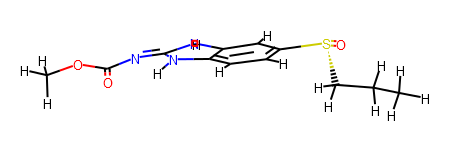

In [126]:
m.molecule

In [ ]:
import h5py
with h5py.File(os.path.join("data","1M_augemented_list.hdf5"),"w") as outfile:
    outfile.create_dataset("icosahedron_level4", data=icosahedron_list_for_SPHERE_PHD)
    outfile.create_dataset("charge", data=augmented_charge_list)
    outfile.create_dataset("molID", data=mol_id_list)


In [44]:
type(icosahedron_list_for_SPHERE_PHD)

list

In [63]:
output_file


<Closed HDF5 file>

In [42]:
m=Chem.rdmolfiles.MolFromSmiles("CC(C)Cc1ccc(cc1)C(C)C(=O)O")

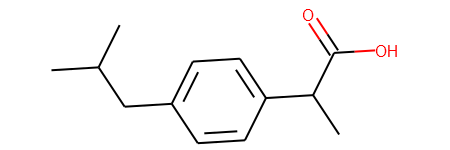

In [43]:
m

In [156]:
m.molecule.GetNumAtoms() # number of atoms
m.molecule.GetNumBonds() # number of bonds
m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
Descriptors.ExactMolWt(m.molecule) # exact molar weight
Descriptors.MolLogP(m.molecule, includeHs=True) # octanol / water partitian coefficient
Descriptors.NumHAcceptors(m.molecule)
Descriptors.NumHDonors(m.molecule)
Descriptors.NumHeteroatoms(m.molecule)
Descriptors.NumValenceElectrons(m.molecule)
Descriptors.NumHeteroatoms(m.molecule)
rdMolDescriptors.CalcPMI1(m.molecule) # principal moment of inertia 1 (smallest)
rdMolDescriptors.CalcPMI2(m.molecule) # principal moment of inertia 2
rdMolDescriptors.CalcPMI3(m.molecule) # principal moment of inertia 3
rdMolDescriptors.CalcSpherocityIndex  (m.molecule)
rdMolDescriptors.CalcAsphericity(m.molecule)
rdMolDescriptors.CalcEccentricity(m.molecule)
rdMolDescriptors.CalcInertialShapeFactor(m.molecule)
rdMolDescriptors.CalcRadiusOfGyration(m.molecule)

4716.020661439631

In [153]:


#rdMolDescriptors.CalcInertialShapeFactor(m.molecule)

4716.020661439631

In [166]:
rdMolDescriptors.CalcRadiusOfGyration(m.molecule)

4.143217621518514

In [161]:
Descriptors.MolLogP(m.molecule, includeHs=True)

2.1639999999999997

In [53]:
dir(m)

['AddConformer',
 'ClearComputedProps',
 'ClearProp',
 'Compute2DCoords',
 'ComputeGasteigerCharges',
 'Debug',
 'GetAromaticAtoms',
 'GetAtomWithIdx',
 'GetAtoms',
 'GetAtomsMatchingQuery',
 'GetBondBetweenAtoms',
 'GetBondWithIdx',
 'GetBonds',
 'GetBoolProp',
 'GetConformer',
 'GetConformers',
 'GetDoubleProp',
 'GetIntProp',
 'GetNumAtoms',
 'GetNumBonds',
 'GetNumConformers',
 'GetNumHeavyAtoms',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetRingInfo',
 'GetStereoGroups',
 'GetSubstructMatch',
 'GetSubstructMatches',
 'GetUnsignedProp',
 'HasProp',
 'HasSubstructMatch',
 'NeedsUpdatePropertyCache',
 'RemoveAllConformers',
 'RemoveConformer',
 'SetBoolProp',
 'SetDoubleProp',
 'SetIntProp',
 'SetProp',
 'SetUnsignedProp',
 'ToBinary',
 'UpdatePropertyCache',
 '__DebugMol',
 '__GetSubstructMatch',
 '__GetSubstructMatches',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',


In [49]:
m.GetPropNames()

<rdkit.rdBase._vectclass std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> > at 0x27568002810>

In [56]:
AllChem.ComputeGasteigerCharges(m)

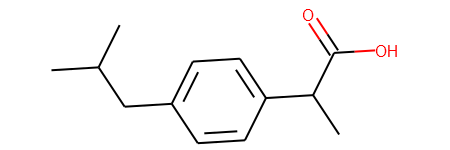

In [57]:
m

In [62]:
for atom in m.GetAtoms():
   print(atom.GetSymbol(), atom.GetExplicitValence(), atom.GetMass(), atom.GetTotalNumHs())

C 1 12.011 3
C 3 12.011 1
C 1 12.011 3
C 2 12.011 2
C 4 12.011 0
C 3 12.011 1
C 3 12.011 1
C 4 12.011 0
C 3 12.011 1
C 3 12.011 1
C 3 12.011 1
C 1 12.011 3
C 4 12.011 0
O 2 15.999 0
O 1 15.999 1


In [61]:
atom.GetMass()

15.999

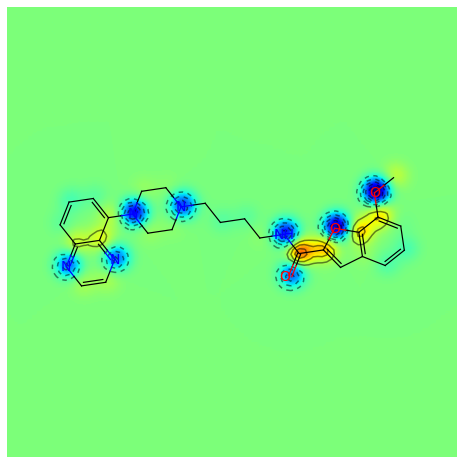

In [149]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)